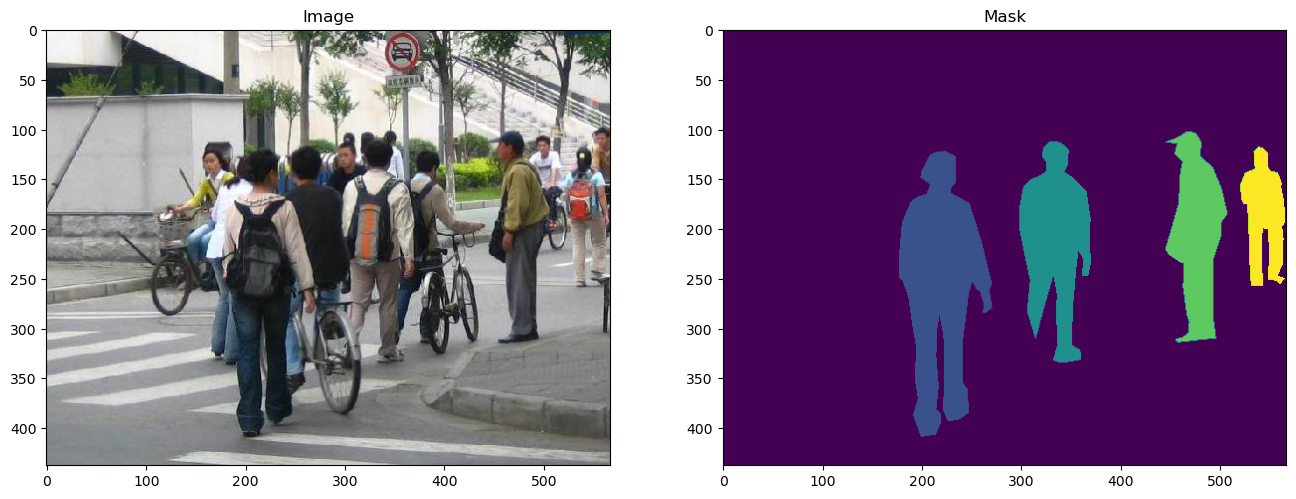

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("data/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [16]:
import os
import torch

from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    #인덱스에 해당하는 이미지 와 마스크(레이블)을 가져오는 역할
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path) #read_image(경로) 는 이미지를 텐서로 변환함
        mask = read_image(mask_path)

        #마스크 이미지 내에서 사용된 모든 고유한 값을 반환함 
        obj_ids = torch.unique(mask)
        #마스크 객체는 각 위치별  뭐가 있는지를 숫자로 반환해주는데, 
        #unique로 중복제거를 하고 나면 그 갯수 다 상관없이 그 화면에 있는 값들만 [0,1,2,3]처럼반환됨.
        obj_ids = obj_ids[1:]
        #고유값 0번째는 배경이므로 제거하고 1부터 [1,2,3] 만 가져옴
        #객체의 아이디값이 저장된 텐서가 됨
        num_objs = len(obj_ids)
        #객체 수 계산함

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        #obj_idx라는 1차원 텐서에 2차원 추가를 해서 3차원 텐서로 변환함
        #[
        #[[1], [1], [1], [1]],
        #[[2], [2], [2], [2]],
        #[[3], [3], [3], [3]]
        #]
        #을 mask 텐서가 가진 1,2,3과 각각 1일때 2일때 3일때 비교하여 불리언으로 반환함
        #그걸 다시 0, 1로 바꿈
        
        boxes = masks_to_boxes(masks)
        #masks_to_boxes 함수는 각 객체 마스크에 대해 바운딩 박스를 계산
        
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        #현재 이미지의 id를 설정하고
        area = (boxes[:, 3] - boxes[:, 1] * (boxes[:, 2] - boxes[:, 0]))
        #각 바운딩 박스의 높이 너비 면적 계산함

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        #각 객체가 군중인지 아닌지를 0과 1로 표시함

        img = tv_tensors.Image(img)
        #이미지를 tv_tensorsImage 객체로 변환함

        #훈련에 필요한 정답 정보들을 저장함 바운딩박스, 객체마스크, 레이블, 이미지 아이등등
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [17]:
import torchvision.transforms.v2 as v2

my_transform = v2.Compose([
    v2.ToTensor()
])

In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2  # 1 class (person) + background

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [20]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [21]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.0789, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0517, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0191, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0043, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [23]:
pip install pycocotools


   ---------------------------------------- 0.0/83.3 kB ? eta -:--:--
   ------------------------ --------------- 51.2/83.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 83.3/83.3 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
dataset = PennFudanDataset('data/PennFudanPed/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

model = get_model_instance_segmentation(num_classes)

model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 2

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\user/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:16<00:00, 10.5MB/s]
C:\practice-torch\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:10:19  lr: 0.000090  loss: 6.2149 (6.2149)  loss_classifier: 0.7923 (0.7923)  loss_box_reg: 0.4049 (0.4049)  loss_mask: 5.0119 (5.0119)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 10.3221  data: 0.0513
Epoch: [0]  [10/60]  eta: 0:07:41  lr: 0.000936  loss: 2.1771 (3.3665)  loss_classifier: 0.5037 (0.5192)  loss_box_reg: 0.3456 (0.3369)  loss_mask: 1.2986 (2.4807)  loss_objectness: 0.0140 (0.0212)  loss_rpn_box_reg: 0.0062 (0.0085)  time: 9.2290  data: 0.0854
Epoch: [0]  [20/60]  eta: 0:06:04  lr: 0.001783  loss: 1.1436 (2.1344)  loss_classifier: 0.2376 (0.3492)  loss_box_reg: 0.2975 (0.2957)  loss_mask: 0.4333 (1.4572)  loss_objectness: 0.0197 (0.0237)  loss_rpn_box_reg: 0.0072 (0.0085)  time: 9.0465  data: 0.0609
Epoch: [0]  [30/60]  eta: 0:04:32  lr: 0.002629  loss: 0.5593 (1.6174)  loss_classifier: 0.0853 (0.2625)  loss_box_reg: 0.1796 (0.2595)  loss_mask: 0.2843 (1.0694)  loss_objectness: 0.0124 (0.0179)  loss_rpn_box_reg:

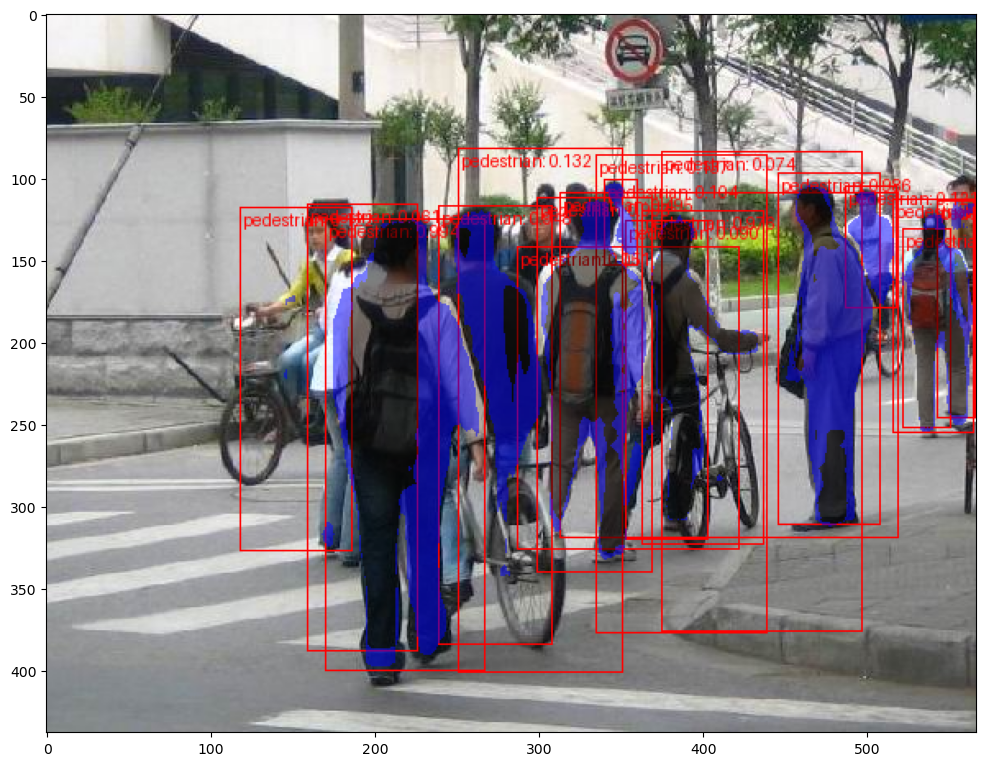

In [27]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))